# Delta Robot Kinematics, Configuration Space, Workspace and Singularity Analysis

## Degrees of Freedom

The delta robot has 3 degrees of freedom. The 3 degrees of freedom are the 3 angles of the 3 arms. The 3 angles are the angles between the arms and the base. The 3 angles are denoted by $\theta_1$, $\theta_2$, and $\theta_3$. The 3 angles are the joint angles of the delta robot. The 3 angles are the configuration space of the delta robot. The configuration space of the delta robot is the space of all possible joint angles of the delta robot. The configuration space of the delta robot is a 3-dimensional space. The configuration space of the delta robot is a 3-dimensional space because the delta robot has 3 degrees of freedom.

<div style="text-align: center;">
  <img src="images/delta_robot_modern_robotics.png" alt="Delta Robot">
</div>

# Configuration Space

The delta robot's configuration space is bound by the 3 motor angles $\theta_1$, $\theta_2$, and $\theta_3$. The configuration space is a 3D space, where each point in the space corresponds to a unique position of the robot's end effector.

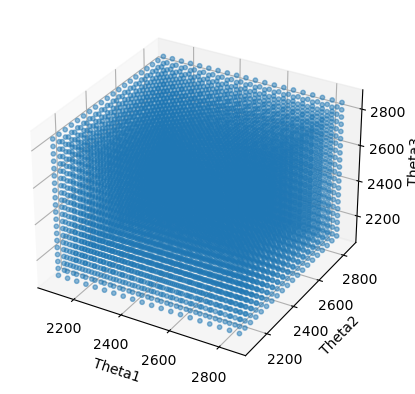

In [1]:
# The C-Space for the delta robot is 3 dimensional for the 3 motors
import numpy as np
import matplotlib.pyplot as plt

# Motor ranges in Dynamixel steps
theta1_range = [2100, 2850]
theta2_range = [2100, 2850]
theta3_range = [2100, 2850]

# Use a smaller number of points for a scatter plot to keep rendering fast
num_points = 20
theta1 = np.linspace(theta1_range[0], theta1_range[1], num_points)
theta2 = np.linspace(theta2_range[0], theta2_range[1], num_points)
theta3 = np.linspace(theta3_range[0], theta3_range[1], num_points)
Theta1, Theta2, Theta3 = np.meshgrid(theta1, theta2, theta3)

# Create a 3D scatter plot of the configuration space points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Theta1.flatten(), Theta2.flatten(),
           Theta3.flatten(), alpha=0.5, s=10)

# Set the labels
ax.set_xlabel('Theta1')
ax.set_ylabel('Theta2')
ax.set_zlabel('Theta3')

# Show the plot
plt.show()

In [2]:
# Robot Constants
sqrt3 = np.sqrt(3)
SB = 261.306  # Base Equilateral Triangle Side Length [mm]
SP = 73.481  # Platform Equilateral Triangle Side Length [mm]
L = 108  # Active Link Length [mm]
ell = 153  # Passive Link Length [mm]
h = 32  # Passive Link Width [mm]
WB = (sqrt3 / 6) * SB
UB = (sqrt3 / 3) * SB
WP = (sqrt3 / 6) * SP
UP = (sqrt3 / 3) * SP

# Inverse Kinematics
https://people.ohio.edu/williams/html/PDF/DeltaKin.pdf

In [3]:
# The analytical solution for IK uses the constraint equations found from the vector-loop closure equations
# E_i * cos(theta_i) + F_i *  sin(theta_i) + G_i = 0

# Variables obtained from the Vector-Loop Closure Equations
a = WB - UP
b = (SP / 2) - (sqrt3 / 2) * WP
c = WP - (WB / 2)

def IK(x,y,z):
  E = (
    2*L*(y+a), # E1
    -L*(sqrt3*(x+b)+y+c), # E2
    L*(sqrt3*(x-b)-y-c) #E3
    )
  F = (
    2*z*ell, # F1
    2*z*ell,  # F2
    2*z*ell,  # F3
  )
  G = (
    x**2 + y**2 + z**2 + a**2 + L**2 + 2*y*a - ell**2, # G1
    x**2 + y**2 + z**2 + b**2 + c**2 + L**2 + 2*(x*b+y*c) - ell**2,  # G2
    x**2 + y**2 + z**2 + b**2 + c**2 + L**2 + 2*(-x*b+y*c) - ell**2,  # G3
  )
  thetas = []
  # Tangent Half-Angle Substitution
  for i in range(3):
    t_plus = (-F[i] + np.sqrt(E[i]**2 + F[i]**2 - G[i]**2)) / (G[i] - E[i])
    t_minus = (-F[i] - np.sqrt(E[i]**2 + F[i]**2 - G[i]**2)) / (G[i] - E[i])
    theta_plus = 2 * np.arctan(t_plus)
    theta_minus = 2 * np.arctan(t_minus)
    thetas.append((theta_plus, theta_minus))
  return thetas # [rad]

# Some Test Cases
home_position = [ sol[0] for sol in IK(0,0,-200) ]
print(home_position) # [theta1, theta2, theta3]

[2.7611675644277316, 2.6236109175908027, 2.6236109175908027]


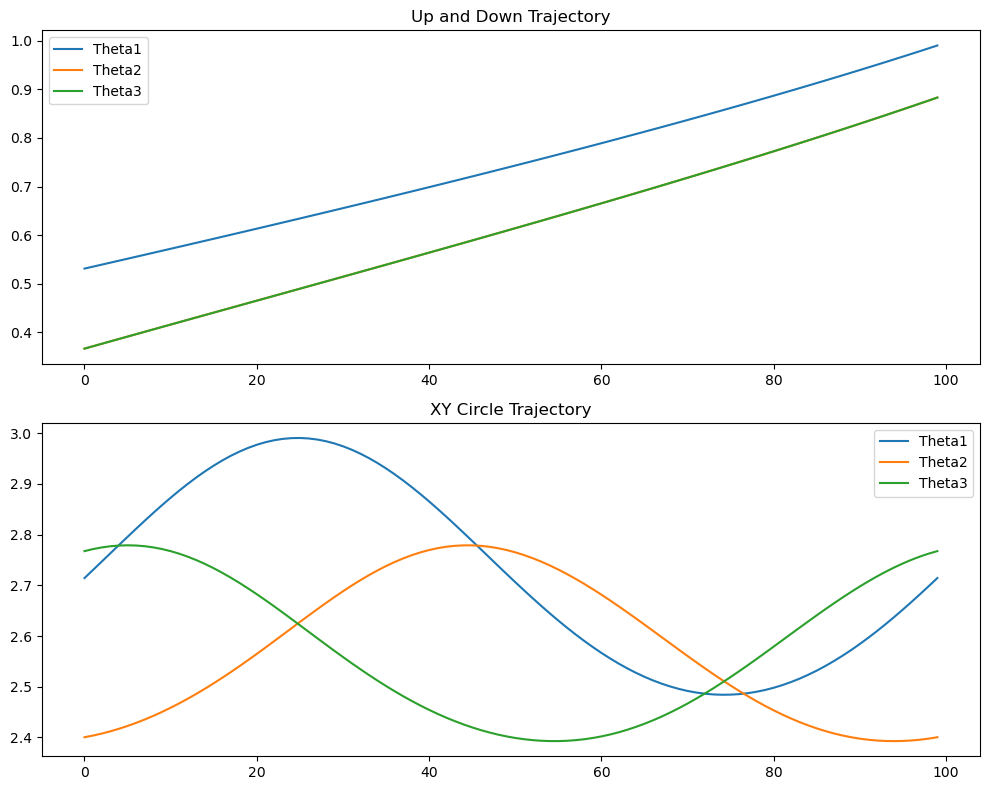

In [4]:
# Plot a simple up and down trajectory
up_and_down = np.linspace(-180, -280, 100)
x = np.zeros(len(up_and_down))
y = np.zeros(len(up_and_down))
z = up_and_down
thetas = np.array([IK(x,y,z) for x,y,z in zip(x,y,z)])

# Trajectory: An XY Circle with a center of (0, 0, -200) mm and a radius of 50 mm
# At the same time, the Z displacement goes through 2 cycles of a sine wave
# centered on Z = -200 mm with an amplitude of 25 mm
t = np.linspace(0, 2*np.pi, 100)
x = 50 * np.cos(t)
y = 50 * np.sin(t)
z = -200 + 25 * np.sin(t)
thetas_circle = np.array([IK(x,y,z) for x,y,z in zip(x,y,z)])

# Plot the trajectories
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the up and down trajectory
axs[0].plot(thetas[:,0,1], label='Theta1')
axs[0].plot(thetas[:,1,1], label='Theta2')
axs[0].plot(thetas[:,2,1], label='Theta3')
axs[0].set_title('Up and Down Trajectory')
axs[0].legend()

# Plot the XY circle trajectory
axs[1].plot(thetas_circle[:,0,0], label='Theta1')
axs[1].plot(thetas_circle[:,1,0], label='Theta2')
axs[1].plot(thetas_circle[:,2,0], label='Theta3')
axs[1].set_title('XY Circle Trajectory')
axs[1].legend()

plt.tight_layout()
plt.show()

# Forward Kinematics


In [5]:
def FK(th1,th2,th3):
  # First determine the centers of the 3 virtual spheres
  sphere_centers = (
    (0, -WB-L*np.cos(th1)+UP, -L*np.sin(th1)), # Sphere 1
    ((sqrt3/2)*(WB+L*np.cos(th2)-(SP/2), 0.5*(WB+L*np.cos(th2))-WP, -L*np.sin(th2))), # Sphere 2
    (-(sqrt3/2)*(WB+L*np.cos(th3)+(SP/2), 0.5*(WB+L*np.cos(th3))-WP, -L*np.sin(th3))),  # Sphere 3
  )
  x1, y1, z1 = sphere_centers[0]
  x2, y2, z2 = sphere_centers[1]
  x3, y3, z3 = sphere_centers[2]
  
  # Determine if the all Z heights of the 3 spheres are the same to determine which algorithm to use
  same_z_height = all([center[2] == sphere_centers[0][2] for center in sphere_centers])
  
  if same_z_height:
    assert z1 == z2 == z3
    z_n = z1 # All Z heights are the same
    a = 2*(x3 - x1)
    b = 2*(y3 - y1)
    c = ell**2 - ell**2 - x1**2 - y1**2 + x3**2 + y3**2
    d = 2*(x3-x2)
    e = 2*(y3-y2)
    f = ell**2 - ell**2 - x2**2 - y2**2 + x3**2 + y3**2
    x = (c*e - b*f) / (a*e - b*d)
    y = (a*f - c*d) / (a*e - b*d)
    A = 1
    B = -2 * z_n
    C = z_n**2 - ell*2 + (x-x1)**2 + (y-y1)**2
    z_plus = (-B + np.sqrt(B**2 - 4*A*C)) / 2*A
    z_minus = (-B - np.sqrt(B**2 - 4*A*C)) / 2*A
    # Choose the Z value that is in the correct workspace (-Z)
    z = z_plus if z_plus < 0 else z_minus
    return x,y,z
  else:
    # 3 Sphere Intersection Algorithm
    pass

# Plotting the Robot's Configuration

In order to better visualize the robot's configuration, we can plot the robot's links and joints in 3D space.

In [7]:
def motor_positions():
  return (
    (0,-WB,0), # B1
    ((sqrt3/2)*WB,WB/2,0), # B2
    (-(sqrt3/2)*WB,WB/2,0) # B3
  )
  
def base_vertices():
  return (
    (SB/2, -WB, 0), # b1
    (0, UB, 0), # b2
    (-SB/2, -WB, 0) # b3
  )

def platform_vertices(platform_position):
  # platform_position is a tuple (x,y,z)
  x, y, z = platform_position
  # Platform vertices with respect to the given platform position
  return (
    (x, y - UP, z), # P1
    (x + SP/2, y + WP, z), # P2
    (x - SP/2, y + WP, z) # P3
  )

def knee_joints(theta1,theta2,theta3):
  knee_1 = (0, -WB-L*np.cos(theta1), -L*np.sin(theta1))
  knee_2 = ((sqrt3/2)*(WB+L*np.cos(theta2)), (1/2)*(WB+L*np.cos(theta2)), -L*np.sin(theta2))
  knee_3 = ((-sqrt3/2)*(WB+L*np.cos(theta3)), (1/2)*(WB+L*np.cos(theta3)), -L*np.sin(theta3))
  return (knee_1, knee_2, knee_3)


def plot_robot(theta1, theta2, theta3):
  # Calculate the knee joint positions
  knee_1, knee_2, knee_3 = knee_joints(theta1, theta2, theta3)
  # Calculate the platform position
  platform_position = FK(theta1, theta2, theta3)
  # Get the base vertices
  bv1, bv2, bv3 = base_vertices()
  # Get the motor positions
  m1, m2, m3 = motor_positions()
  # Get the platform vertices
  pv1, pv2, pv3 = platform_vertices(platform_position)
  
  # Create a 3D plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  
  # Draw the Base Triangle centered at the origin with
  # the vertices at the calculated positions
  ax.plot_trisurf([bv1[0], bv2[0], bv3[0]], [bv1[1], bv2[1], bv3[1]], [bv1[2], bv2[2], bv3[2]])
  
  # Draw small rectangles at the motor positions in the same plane as the base triangle XY plane
  motor_width = 10
  motor_length = 20
  for m in [m1, m2, m3]:
    m_x, m_y, m_z = m
    # Draw a 2D rectangle centered at the motor position
    ax.plot([m_x - motor_length/2, m_x + motor_length/2], [m_y - motor_width/2, m_y - motor_width/2], [m_z, m_z])
  
  
  # Draw the Platform Triangle centered at the platform position
  # with the vertices at the calculated positions
  ax.plot_trisurf([pv1[0], pv2[0], pv3[0]], [pv1[1], pv2[1], pv3[1]], [pv1[2], pv2[2], pv3[2]])